In [1]:
!pip install gdown
!pip install tensorflow
!pip install --upgrade opencv-python

In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn.model_selection
import random
from tensorflow.keras import layers, Model

In [3]:
# to download from
file_id = "1el92N8lBia2a5RFK0leeFQFRyhsEXaZx"
!gdown --id {file_id} -O rare_species.zip


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx
From (redirected): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx&confirm=t&uuid=3002e461-2f60-484c-b163-36b4e9c91607
To: /content/rare_species.zip
100% 4.26G/4.26G [00:47<00:00, 90.4MB/s]


In [4]:
# verify file size
!ls -lh rare_species.zip

-rw-r--r-- 1 root root 4.0G Apr 11 12:01 rare_species.zip


In [5]:
# directory creation for excation
extract_path = '/content/rare_species'
if not os.path.exists(extract_path):
    os.makedirs(extract_path)
    print(f"Created directory: {extract_path}")

Created directory: /content/rare_species


In [6]:
# extraction
print("Extracting zip ")
with zipfile.ZipFile('rare_species.zip', 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Extraction complete")

Extracting zip 
Extraction complete


In [7]:
# list fo contents for double-check
!ls -la {extract_path}

total 2936
drwxr-xr-x 204 root root   12288 Apr 18 13:52 .
drwxr-xr-x   1 root root    4096 Apr 18 13:51 ..
drwxr-xr-x   2 root root   12288 Apr 18 13:51 arthropoda_apidae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_attelabidae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_carabidae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_cerambycidae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_coenagrionidae
drwxr-xr-x   2 root root   20480 Apr 18 13:51 arthropoda_formicidae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_gomphidae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_lucanidae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_nymphalidae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_palinuridae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_papilionidae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_pisauridae
drwxr-xr-x   2 root root    4096 Apr 18 13:51 arthropoda_platystictidae


In [8]:
csv_files = [f for f in os.listdir(extract_path) if f.endswith('.csv')]
print(f"Found CSV files: {csv_files}")

if csv_files:
    metadata_path = os.path.join(extract_path, csv_files[0])
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with shape: {metadata.shape}")
    print(metadata.head())
else:
    print("No CSV file found.")

Found CSV files: ['metadata.csv']
Loaded metadata with shape: (11983, 7)
                        rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_tur

In [9]:
# Dropper les colonnes inutiles
columns_to_keep = ['file_path', 'family', 'phylum']  # Garder seulement ce qui est nécessaire
metadata = metadata[columns_to_keep]
print('Colonnes restantes:', metadata.columns.tolist())

Colonnes restantes: ['file_path', 'family', 'phylum']


In [10]:
metadata.head()

,file_path,family,phylum
0,mollusca_unionidae/12853737_449393_eol-full-si...,unionidae,mollusca
1,chordata_geoemydidae/20969394_793083_eol-full-...,geoemydidae,chordata
2,chordata_cryptobranchidae/28895411_319982_eol-...,cryptobranchidae,chordata
3,chordata_turdidae/29658536_45510188_eol-full-s...,turdidae,chordata
4,chordata_indriidae/21252576_7250886_eol-full-s...,indriidae,chordata


# EDA

# Preprocessing of Yasmine


Visualisation des images avant/après prétraitement et augmentations


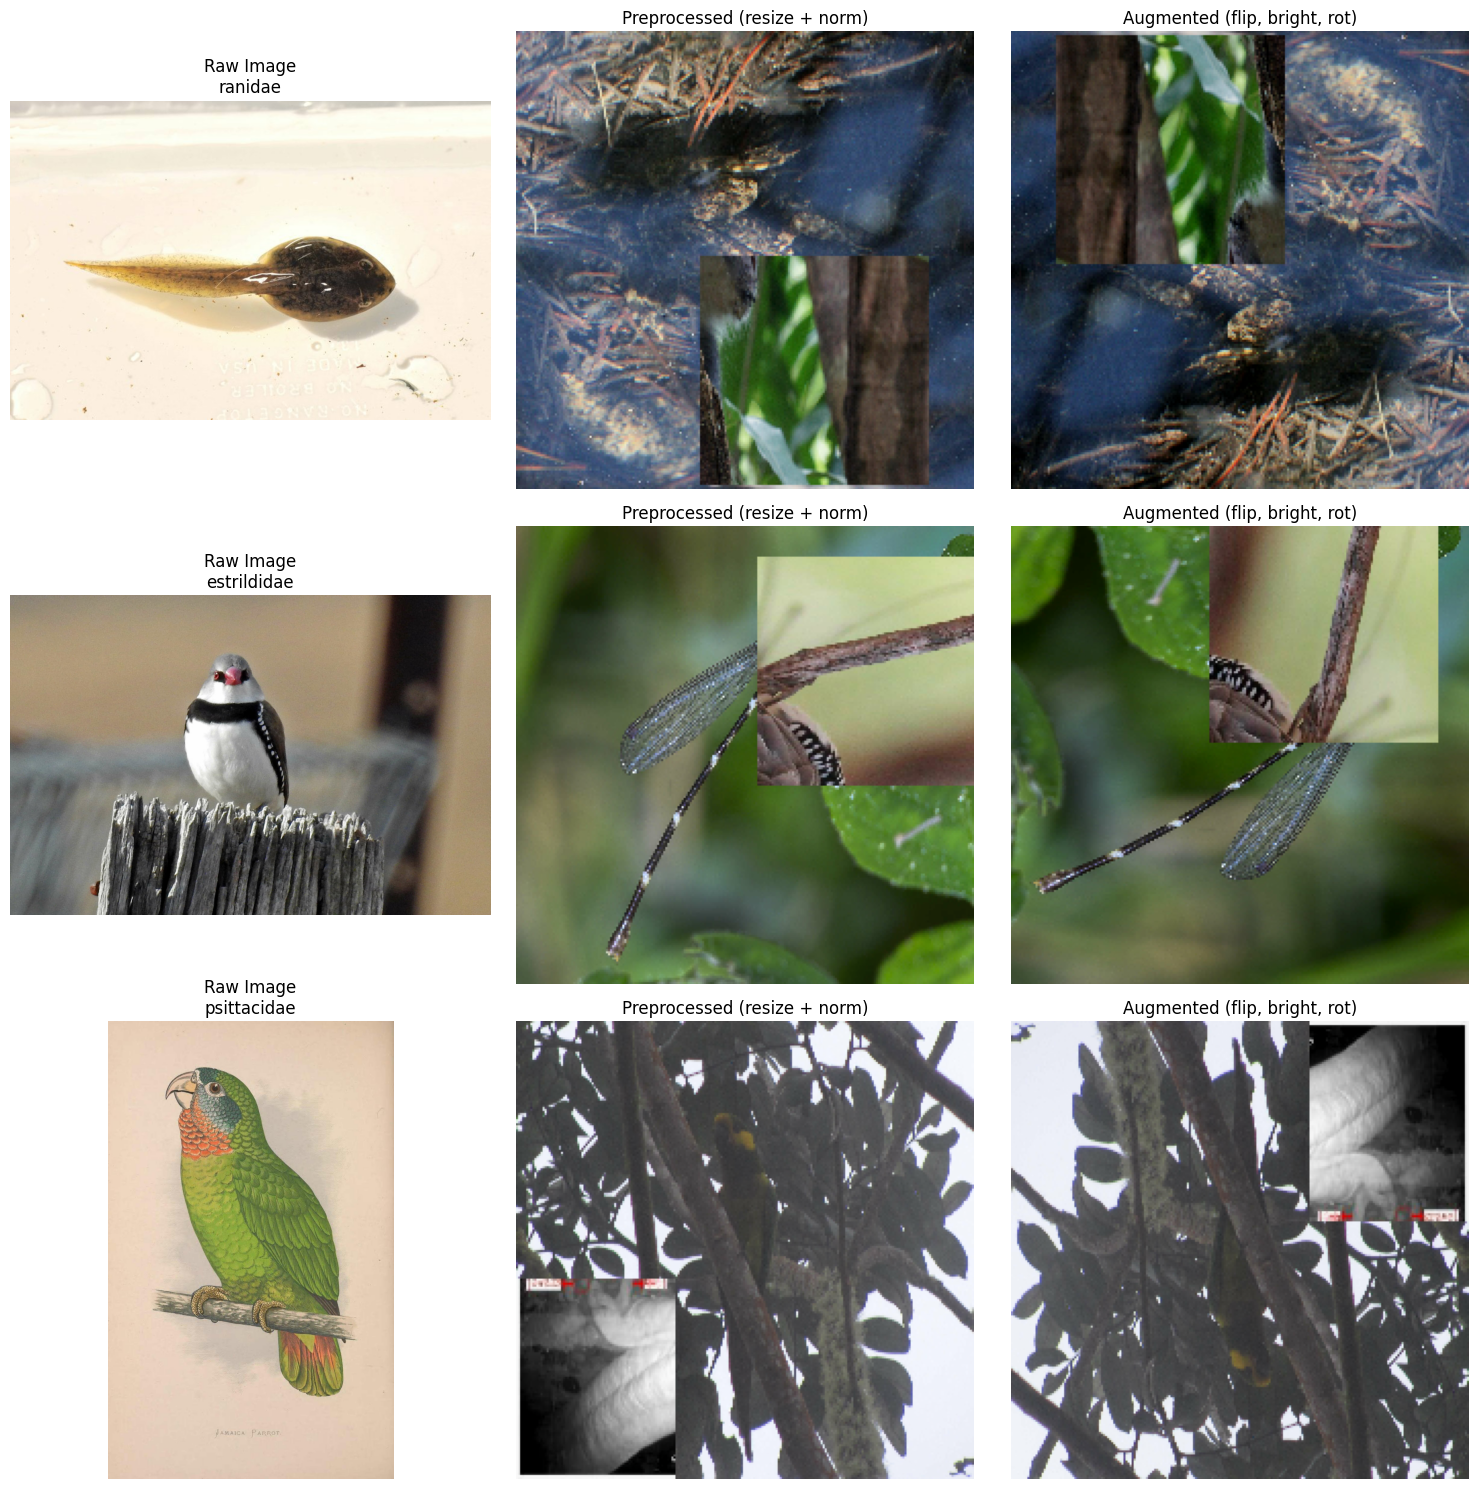

In [17]:
import tensorflow as tf
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

# Configuration
DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Normalisation ImageNet
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# Métrique personnalisée pour Macro F1
class MacroF1(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='macro_f1', **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)  # (batch_size,)
        y_pred = tf.argmax(y_pred, axis=-1, output_type=tf.int32)  # (batch_size,)

        classes = tf.range(self.num_classes)  # (num_classes,)
        true_mask = tf.equal(tf.expand_dims(y_true, -1), classes)  # (batch_size, num_classes)
        pred_mask = tf.equal(tf.expand_dims(y_pred, -1), classes)  # (batch_size, num_classes)

        tp = tf.reduce_sum(tf.cast(tf.logical_and(true_mask, pred_mask), tf.float32), axis=0)
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(true_mask), pred_mask), tf.float32), axis=0)
        fn = tf.reduce_sum(tf.cast(tf.logical_and(true_mask, tf.logical_not(pred_mask)), tf.float32), axis=0)

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + 1e-10)
        recall = self.true_positives / (self.true_positives + self.false_negatives + 1e-10)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
        return tf.reduce_mean(f1)

    def reset_states(self):
        self.true_positives.assign(tf.zeros_like(self.true_positives))
        self.false_positives.assign(tf.zeros_like(self.false_positives))
        self.false_negatives.assign(tf.zeros_like(self.false_negatives))

# Fonctions globales pour le pipeline
@tf.function
def preprocess(file_path, family, phylum, family_lookup, phylum_lookup):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    img = (img - IMAGENET_MEAN) / IMAGENET_STD
    img = tf.ensure_shape(img, [224, 224, 3])
    phylum_idx = phylum_lookup(phylum)
    family_idx = family_lookup(family)
    return (img, phylum_idx), family_idx

@tf.function
def augment(image_phylum, label):
    image, phylum = image_phylum
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    image = tf.ensure_shape(image, [224, 224, 3])
    return (image, phylum), label

@tf.function
def cutmix(image_phylum, label):
    image, phylum = image_phylum
    label = tf.ensure_shape(label, [None])

    batch_size = tf.shape(image)[0]
    lam = tf.random.uniform([], minval=0.5, maxval=1.0, dtype=tf.float32)

    idx = tf.random.shuffle(tf.range(batch_size))
    img_a = image
    img_b = tf.gather(image, idx)
    lbl_a = label
    lbl_b = tf.gather(label, idx)

    height, width = IMG_SIZE[0], IMG_SIZE[1]
    y = tf.random.uniform([], 0, height, dtype=tf.int32)
    x = tf.random.uniform([], 0, width, dtype=tf.int32)
    y1 = tf.clip_by_value(y - height // 4, 0, height)
    y2 = tf.clip_by_value(y + height // 4, 0, height)
    x1 = tf.clip_by_value(x - width // 4, 0, width)
    x2 = tf.clip_by_value(x + width // 4, 0, width)

    mask = tf.ones_like(img_a, dtype=tf.float32)
    y_indices = tf.tile(tf.expand_dims(tf.range(height), 1), [1, width])
    x_indices = tf.tile(tf.expand_dims(tf.range(width), 0), [height, 1])
    mask_patch = tf.logical_and(
        tf.logical_and(y_indices >= y1, y_indices < y2),
        tf.logical_and(x_indices >= x1, x_indices < x2)
    )
    mask_patch = tf.expand_dims(mask_patch, 0)
    mask_patch = tf.expand_dims(mask_patch, -1)
    mask_patch = tf.tile(mask_patch, [batch_size, 1, 1, 3])
    mask = tf.where(mask_patch, tf.zeros_like(mask), mask)
    mask = tf.cast(mask, tf.float32)

    image = img_a * mask + img_b * (1. - mask)
    image = tf.ensure_shape(image, [None, 224, 224, 3])

    label = tf.where(tf.random.uniform([]) < lam, lbl_a, lbl_b)

    return (image, phylum), label

# 1. Préparation des données
def prepare_datasets(data_path):
    if not os.path.exists(data_path + '/metadata.csv'):
        raise FileNotFoundError(f"Metadata file not found at {data_path}/metadata.csv")

    metadata = pd.read_csv(data_path + '/metadata.csv')
    metadata['file_exists'] = metadata['file_path'].apply(lambda x: os.path.exists(data_path + '/' + x))
    metadata = metadata[metadata['file_exists']]

    if len(metadata) == 0:
        raise ValueError("No valid images found in the dataset")

    metadata = metadata[['file_path', 'family', 'phylum']]

    file_paths = [os.path.join(data_path, fp) for fp in metadata['file_path'].values]
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    if len(file_paths) < 10:
        print(f"Warning: Small dataset size ({len(file_paths)} images). Consider adding more data.")

    train_paths, val_paths, train_families, val_families, train_phyla, val_phyla = train_test_split(
        file_paths, family_labels, phylum_labels,
        test_size=0.2,
        stratify=family_labels,
        random_state=SEED
    )

    # MAX_TRAIN = 500
    # MAX_VAL = 100

    # train_paths = train_paths[:MAX_TRAIN]
    # val_paths = val_paths[:MAX_VAL]
    # train_families = train_families[:MAX_TRAIN]
    # val_families = val_families[:MAX_VAL]
    # train_phyla = train_phyla[:MAX_TRAIN]
    # val_phyla = val_phyla[:MAX_VAL]

    family_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    family_lookup.adapt(train_families)
    phylum_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    phylum_lookup.adapt(phylum_labels)

    train_classes = set(np.unique(train_families))
    val_classes = set(np.unique(val_families))
    missing_in_train = val_classes - train_classes
    if missing_in_train:
        print(f"Warning: {len(missing_in_train)} classes in val but not in train: {missing_in_train}")

    unique_classes, counts = np.unique(train_families, return_counts=True)
    class_weights = {family_lookup(cls).numpy(): 1.0 / count for cls, count in zip(unique_classes, counts)}
    total = sum(class_weights.values())
    class_weights = {k: v / total * len(class_weights) for k, v in class_weights.items()}

    train_family_indices = [family_lookup(f).numpy() for f in train_families]

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_families, train_phyla))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_families, val_phyla))

    train_ds = train_ds.shuffle(buffer_size=1000, seed=SEED)
    train_ds = train_ds.map(
        lambda x, y, z: preprocess(x, y, z, family_lookup, phylum_lookup),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)
    train_ds = train_ds.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)

    val_ds = val_ds.map(
        lambda x, y, z: preprocess(x, y, z, family_lookup, phylum_lookup),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True)

    train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, family_lookup, phylum_lookup, class_weights, train_paths, train_families, train_phyla, train_family_indices

# 2. Visualisation avant/après
def visualize_preprocessing(train_ds, train_paths, train_families, train_phyla, family_lookup, train_family_indices, num_examples=3):
    def denormalize(img):
        img = img * IMAGENET_STD + IMAGENET_MEAN
        img = tf.clip_by_value(img, 0.0, 1.0)
        return img

    plt.figure(figsize=(15, num_examples * 5))

    for i, ((img, phylum), label) in enumerate(train_ds.take(num_examples)):
        label_scalar = label.numpy()[0]
        try:
            idx = train_family_indices.index(label_scalar)
            file_path = train_paths[idx]
        except ValueError:
            print(f"Warning: No matching file_path found for label {label_scalar}. Skipping.")
            continue

        raw_img = tf.io.read_file(file_path)
        raw_img = tf.image.decode_jpeg(raw_img, channels=3)
        raw_img = tf.cast(raw_img, tf.float32) / 255.0

        preprocessed_img = denormalize(img[0])

        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(raw_img)
        plt.title(f"Raw Image\n{family_lookup.get_vocabulary()[label_scalar]}")
        plt.axis('off')

        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(preprocessed_img)
        plt.title("Preprocessed (resize + norm)")
        plt.axis('off')

        aug_img, _ = augment((img[0], phylum[0]), label[0])
        aug_img = denormalize(aug_img[0])
        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(aug_img)
        plt.title("Augmented (flip, bright, rot)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 3. Créer les datasets
try:
    train_ds, val_ds, family_lookup, phylum_lookup, class_weights, train_paths, train_families, train_phyla, train_family_indices = prepare_datasets(DATA_PATH)
    NUM_FAMILIES = len(family_lookup.get_vocabulary())
    NUM_PHYLA = len(phylum_lookup.get_vocabulary())
except Exception as e:
    print(f"Error in prepare_datasets: {e}")
    raise

# 4. Visualiser
print("Visualisation des images avant/après prétraitement et augmentations")
visualize_preprocessing(train_ds, train_paths, train_families, train_phyla, family_lookup, train_family_indices)

# 5. Focal Loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=NUM_FAMILIES)
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=False)
        pt = tf.reduce_sum(y_true * y_pred, axis=-1)
        loss = alpha * tf.pow(1.0 - pt, gamma) * ce
        return tf.reduce_mean(loss)
    return focal

# ACC of 12%

In [18]:
# Função para criar o modelo com VGG16
def build_vgg16_model(num_phyla, num_families):
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3)
    )
    base_model.trainable = False  # congelar os pesos da VGG16

    image_input = tf.keras.Input(shape=(224, 224, 3), name='image')
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name='phylum')

    x = base_model(image_input, training=False)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])

    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-3))(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    output = tf.keras.layers.Dense(num_families, activation='softmax', name='family')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name="VGG16_Model")

# Construir o modelo
vgg_model = build_vgg16_model(num_phyla=NUM_PHYLA, num_families=NUM_FAMILIES)

# Compilar
vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=focal_loss(),
    metrics=['accuracy', MacroF1(num_classes=NUM_FAMILIES)],
    jit_compile=False
)

vgg_history = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    steps_per_epoch=max(1, len(train_paths) // BATCH_SIZE),
    class_weight=class_weights)

Epoch 1/50
599/599 ━━━━━━━━━━━━━━━━━━━━ 92s 150ms/step - accuracy: 0.0206 - loss: 1.0533 - macro_f1: 0.0014 - val_accuracy: 0.0243 - val_loss: 1.2459 - val_macro_f1: 2.3400e-04
Epoch 2/50
599/599 ━━━━━━━━━━━━━━━━━━━━ 52s 88ms/step - accuracy: 0.0268 - loss: 0.8617 - macro_f1: 0.0010 - val_accuracy: 0.0243 - val_loss: 1.2375 - val_macro_f1: 2.3400e-04
Epoch 3/50
599/599 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - accuracy: 0.0222 - loss: 0.8554 - macro_f1: 0.0011 - val_accuracy: 0.0243 - val_loss: 1.2370 - val_macro_f1: 2.3400e-04
Epoch 4/50
599/599 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - accuracy: 0.0204 - loss: 0.8557 - macro_f1: 8.3285e-04 - val_accuracy: 0.0243 - val_loss: 1.2369 - val_macro_f1: 2.3400e-04
Epoch 5/50
599/599 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - accuracy: 0.0237 - loss: 0.8556 - macro_f1: 0.0011 - val_accuracy: 0.0243 - val_loss: 1.2369 - val_macro_f1: 2.3400e-04
Epoch 6/50
599/599 ━━━━━━━━━━━━━━━━━━━━ 52s 87ms/step - accuracy: 0.0238 - loss: 0.8556 - macro_f1: 9.7293e-04 - va

KeyboardInterrupt: 

# TESTE 1 – Usar loss clássico e fine-tuning das últimas camadas

In [ ]:
model = build_vgg16_model(NUM_PHYLA, NUM_FAMILIES, trainable=True)

# Fine-tuning só últimas camadas
for layer in model.layers[1].layers[:-4]:  # model.layers[1] → base_model
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(train_ds, validation_data=val_ds, epochs=20)


# different approach with 4 different models and a small part of the data set: MAX_TRAIN = 500, MAX_VAL = 100


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


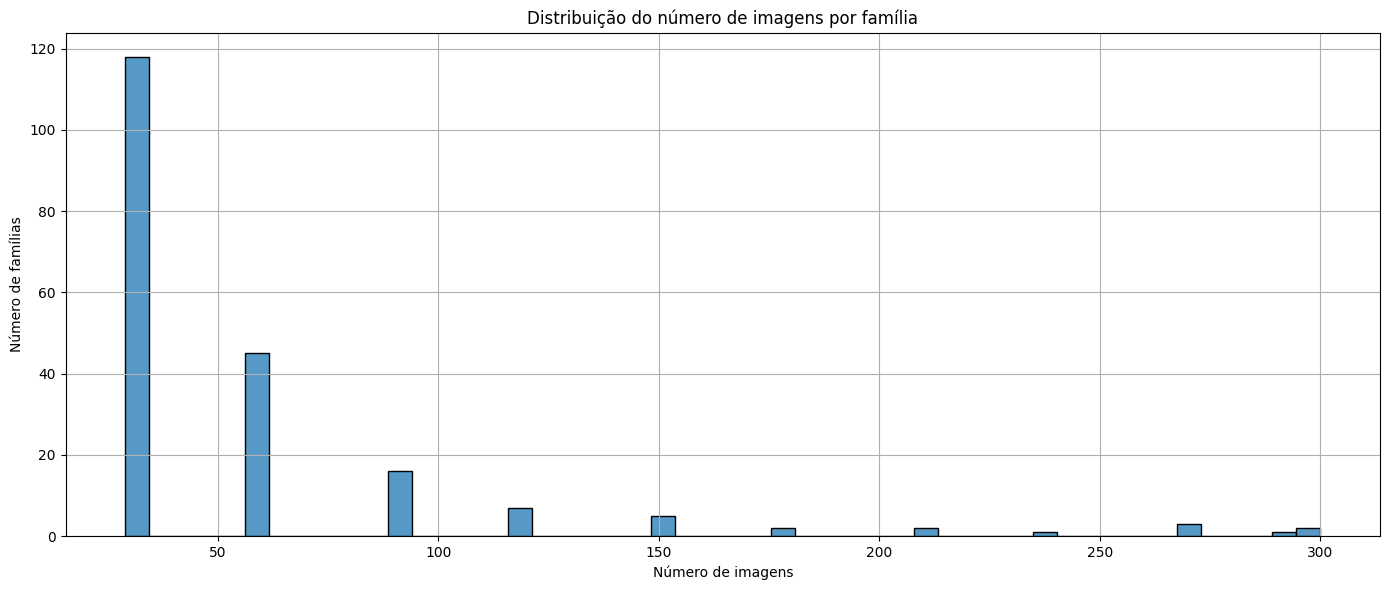

Famílias com menos de 10 imagens:
Series([], Name: count, dtype: int64)
✅ Dados carregados e prontos


In [19]:
# Improved Preprocessing + Model Analysis (versão com base no teu setup)

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image

# Configurações gerais
DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Normalização baseada no ImageNet
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# 1. FILTRAR IMAGENS COM QUALIDADE BAIXA

def is_valid_image(path, min_resolution=(100, 100)):
    try:
        img = Image.open(path)
        return img.size[0] >= min_resolution[0] and img.size[1] >= min_resolution[1]
    except:
        return False

def load_and_clean_metadata(data_path):
    metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
    metadata['full_path'] = metadata['file_path'].apply(lambda x: os.path.join(data_path, x))
    metadata['valid'] = metadata['full_path'].apply(lambda x: os.path.exists(x) and is_valid_image(x))
    return metadata[metadata['valid'] == True]

# 2. ANALISAR FAMILIAS

def analyze_classes(metadata):
    family_counts = metadata['family'].value_counts()
    plt.figure(figsize=(14, 6))
    sns.histplot(family_counts, bins=50, kde=False)
    plt.title("Distribuição do número de imagens por família")
    plt.xlabel("Número de imagens")
    plt.ylabel("Número de famílias")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Famílias com menos de 10 imagens:")
    print(family_counts[family_counts < 10])

# 3. PREPARAR OS DADOS (com classes garantidas em treino/validação)

def prepare_datasets_cleaned(metadata):
    file_paths = metadata['full_path'].values
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    train_paths, val_paths, train_families, val_families, train_phyla, val_phyla = train_test_split(
        file_paths, family_labels, phylum_labels,
        test_size=0.2, stratify=family_labels, random_state=SEED
    )

    # MAX_TRAIN = 500
    # MAX_VAL = 100

    # train_paths = train_paths[:MAX_TRAIN]
    # val_paths = val_paths[:MAX_VAL]
    # train_families = train_families[:MAX_TRAIN]
    # val_families = val_families[:MAX_VAL]
    # train_phyla = train_phyla[:MAX_TRAIN]
    # val_phyla = val_phyla[:MAX_VAL]

    family_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    family_lookup.adapt(train_families)
    phylum_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    phylum_lookup.adapt(train_phyla)

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_families, train_phyla))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_families, val_phyla))

    def preprocess(file_path, family, phylum):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = tf.ensure_shape(img, [224, 224, 3])
        phylum_idx = phylum_lookup(phylum)
        family_idx = family_lookup(family)
        return (img, phylum_idx), family_idx

    def augment(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32))
        return (image, phylum), label

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, family_lookup, phylum_lookup, train_families, val_families

# CHAMAR FLUXO COMPLETO
metadata = load_and_clean_metadata(DATA_PATH)
analyze_classes(metadata)
train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = prepare_datasets_cleaned(metadata)

NUM_FAMILIES = len(family_lookup.get_vocabulary())
NUM_PHYLA = len(phylum_lookup.get_vocabulary())
print("✅ Dados carregados e prontos")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 116s 164ms/step - accuracy: 0.0521 - loss: 5.0140 - val_accuracy: 0.1594 - val_loss: 3.9599
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - accuracy: 0.1538 - loss: 3.9166 - val_accuracy: 0.2115 - val_loss: 3.3803
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 92s 142ms/step - accuracy: 0.1940 - loss: 3.4644 - val_accuracy: 0.2420 - val_loss: 3.1298
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.2287 - loss: 3.2173 - val_accuracy: 0.2970 - val_loss: 2.9092
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 97s 149ms/step - accuracy: 0.2492 - loss: 3.0448 - val_accuracy: 0.3187 - val_loss: 2.7734
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.2827 - loss: 2.9207 - val_accuracy: 0.3287 - val_loss: 2.6876
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 96s 148ms/step - accuracy: 0.2975 - loss: 2.7746 - val_accuracy: 0.3471

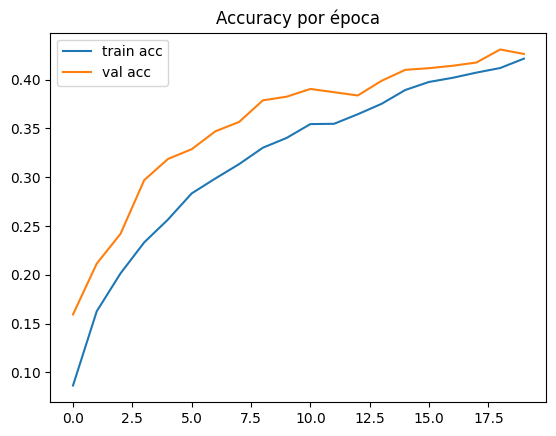

In [20]:
# ---------------------------------------------
# ✅ BLOCO 6: DEFINIÇÃO DE MODELOS PRONTOS
# ---------------------------------------------

def build_pretrained_model(base_model, name, num_phyla, num_families):
    base_model.trainable = False
    image_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = base_model(image_input, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    x = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name=name)

# Exemplos de uso:
model_vgg16 = build_pretrained_model(
    tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "VGG16_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary())
)

model_resnet = build_pretrained_model(
    tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "ResNet50_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))

model_efficient = build_pretrained_model(
    tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "EfficientNetB0_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))

# ---------------------------------------------
# ✅ BLOCO 7: MODELO PERSONALIZADO
# ---------------------------------------------
def build_custom_cnn(num_phyla, num_families):
    img_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, phylum_input], outputs=output, name="CustomCNN")

# ---------------------------------------------
# ✅ BLOCO 8: INSTRUÇÕES PARA TREINO
# ---------------------------------------------

# Podes agora compilar e treinar qualquer um dos modelos assim:
model = model_vgg16  # ou model_resnet, model_efficient, build_custom_cnn(...)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()


por correr

In [ ]:
# Podes agora compilar e treinar qualquer um dos modelos assim:
model1 = model_vgg16  # ou model_resnet, model_efficient, build_custom_cnn(...)
model1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

por correr

In [ ]:
# Podes agora compilar e treinar qualquer um dos modelos assim:
model1_1 = model_vgg16  # ou model_resnet, model_efficient, build_custom_cnn(...)
model1_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model1_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 110s 150ms/step - accuracy: 0.0350 - loss: 5.1262 - val_accuracy: 0.0955 - val_loss: 4.6414
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 86s 131ms/step - accuracy: 0.0869 - loss: 4.5478 - val_accuracy: 0.1135 - val_loss: 4.1793
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 88s 134ms/step - accuracy: 0.1081 - loss: 4.2106 - val_accuracy: 0.1460 - val_loss: 4.0107
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 87s 133ms/step - accuracy: 0.1231 - loss: 4.0732 - val_accuracy: 0.1485 - val_loss: 3.9434
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.1379 - loss: 4.0036 - val_accuracy: 0.1619 - val_loss: 3.8752
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 127ms/step - accuracy: 0.1411 - loss: 3.9306 - val_accuracy: 0.1681 - val_loss: 3.8259
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.1478 - loss: 3.8898 - val_accuracy: 0.1752 - val_loss: 3.7849
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.1523 - loss: 

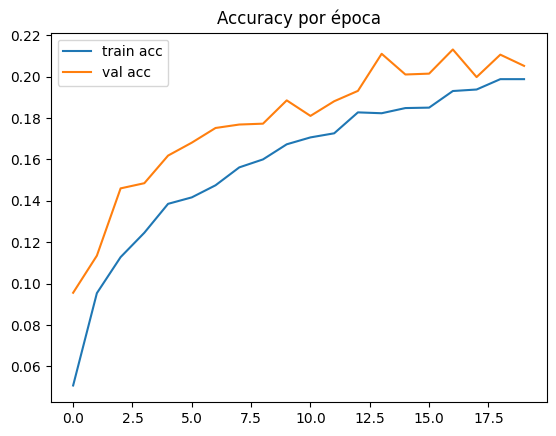

In [21]:
# Podes agora compilar e treinar qualquer um dos modelos assim:
model = model_resnet  # ou model_resnet, model_efficient, build_custom_cnn(...)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.0230 - loss: 5.1608 - val_accuracy: 0.0622 - val_loss: 4.9079
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - accuracy: 0.0494 - loss: 4.7983 - val_accuracy: 0.0705 - val_loss: 4.5627
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - accuracy: 0.0548 - loss: 4.5923 - val_accuracy: 0.0751 - val_loss: 4.4939
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.0674 - loss: 4.5237 - val_accuracy: 0.0884 - val_loss: 4.3893
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - accuracy: 0.0795 - loss: 4.4408 - val_accuracy: 0.0943 - val_loss: 4.3327
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 124ms/step - accuracy: 0.0757 - loss: 4.3797 - val_accuracy: 0.0972 - val_loss: 4.3030
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 80s 122ms/step - accuracy: 0.0832 - loss: 4.3390 - val_accuracy: 0.1076 - val_loss: 4.2516
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - accuracy: 0.0830 - loss: 

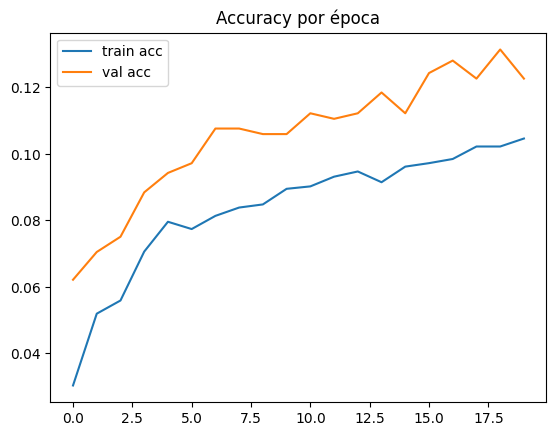

In [22]:
# Podes agora compilar e treinar qualquer um dos modelos assim:
model = model_efficient  # ou model_resnet, model_efficient, build_custom_cnn(...)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

Epoch 1/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 135ms/step - accuracy: 0.0262 - loss: 5.8238 - val_accuracy: 0.0601 - val_loss: 4.6123
Epoch 2/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.0619 - loss: 4.6107 - val_accuracy: 0.0805 - val_loss: 4.3824
Epoch 3/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 127ms/step - accuracy: 0.0755 - loss: 4.4406 - val_accuracy: 0.0914 - val_loss: 4.2860
Epoch 4/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.0858 - loss: 4.3445 - val_accuracy: 0.0968 - val_loss: 4.2495
Epoch 5/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 127ms/step - accuracy: 0.0954 - loss: 4.2714 - val_accuracy: 0.1097 - val_loss: 4.2036
Epoch 6/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 127ms/step - accuracy: 0.1121 - loss: 4.1388 - val_accuracy: 0.1247 - val_loss: 4.1666
Epoch 7/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.1438 - loss: 3.9854 - val_accuracy: 0.1089 - val_loss: 4.1771
Epoch 8/20
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.1688 - loss: 3

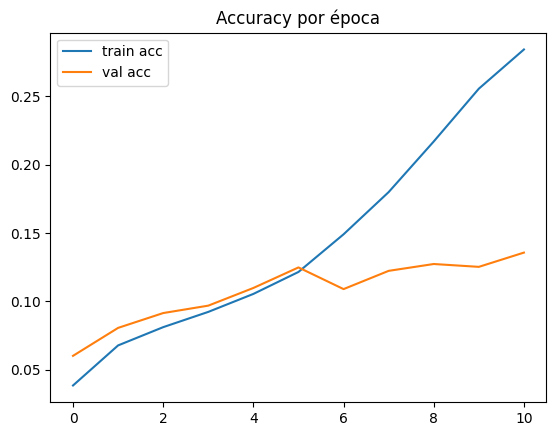

In [23]:
# Podes agora compilar e treinar qualquer um dos modelos assim:
model = build_custom_cnn(len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

# New try


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


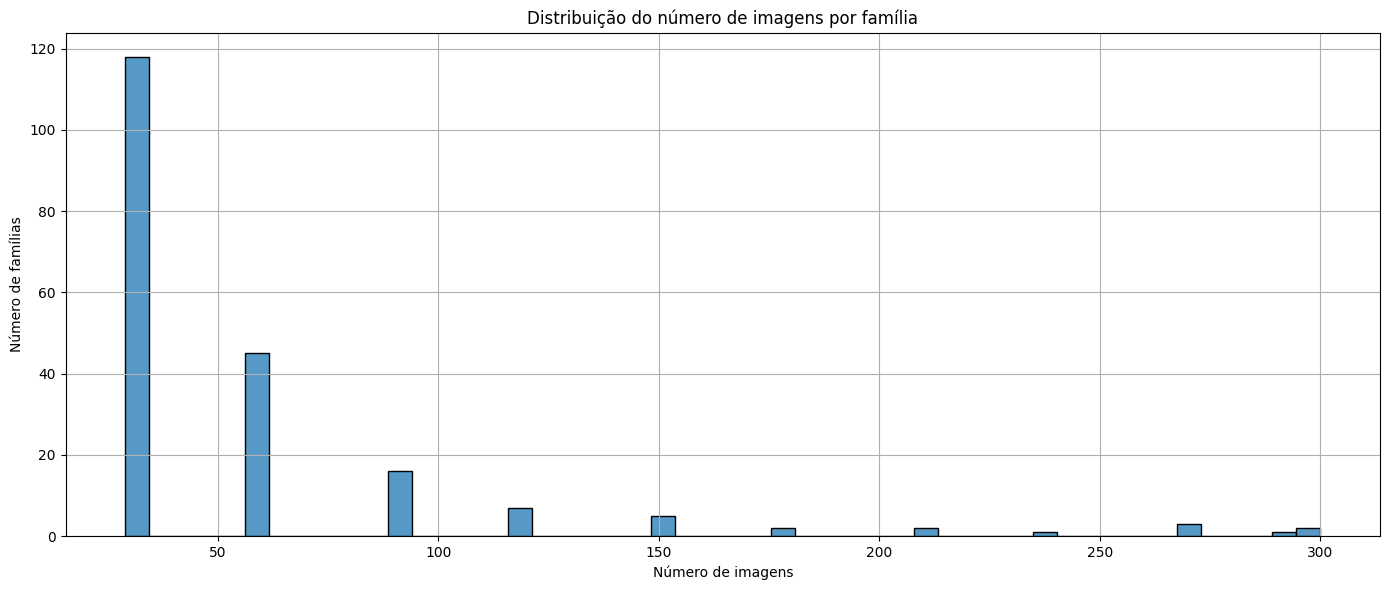

Famílias com menos de 10 imagens:
Series([], Name: count, dtype: int64)
Dados carregados e prontos


In [25]:
# Improved Preprocessing + Model Analysis (versão final para testes)

import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping

# Configurações gerais
DATA_PATH = "/content/rare_species"
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Normalização baseada no ImageNet
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)

# ---------- FILTRAGEM DE IMAGENS COM QUALIDADE BAIXA ----------
def is_valid_image(path, min_resolution=(100, 100)):
    try:
        img = Image.open(path)
        return img.size[0] >= min_resolution[0] and img.size[1] >= min_resolution[1]
    except:
        return False

def load_and_clean_metadata(data_path):
    metadata = pd.read_csv(os.path.join(data_path, 'metadata.csv'))
    metadata['full_path'] = metadata['file_path'].apply(lambda x: os.path.join(data_path, x))
    metadata['valid'] = metadata['full_path'].apply(lambda x: os.path.exists(x) and is_valid_image(x))
    return metadata[metadata['valid'] == True]

# ---------- ANÁLISE DAS CLASSES ----------
def analyze_classes(metadata):
    family_counts = metadata['family'].value_counts()
    plt.figure(figsize=(14, 6))
    sns.histplot(family_counts, bins=50, kde=False)
    plt.title("Distribuição do número de imagens por família")
    plt.xlabel("Número de imagens")
    plt.ylabel("Número de famílias")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("Famílias com menos de 10 imagens:")
    print(family_counts[family_counts < 10])

# ---------- PREPARAÇÃO DO DATASET ----------
def prepare_datasets_cleaned(metadata):
    file_paths = metadata['full_path'].values
    family_labels = metadata['family'].values
    phylum_labels = metadata['phylum'].values

    train_paths, val_paths, train_families, val_families, train_phyla, val_phyla = train_test_split(
        file_paths, family_labels, phylum_labels,
        test_size=0.2, stratify=family_labels, random_state=SEED
    )

    family_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    family_lookup.adapt(train_families)
    phylum_lookup = tf.keras.layers.StringLookup(num_oov_indices=1, output_mode='int')
    phylum_lookup.adapt(train_phyla)

    train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_families, train_phyla))
    val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_families, val_phyla))

    def preprocess(file_path, family, phylum):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        img = (img - IMAGENET_MEAN) / IMAGENET_STD
        img = tf.ensure_shape(img, [224, 224, 3])
        return (img, phylum_lookup(phylum)), family_lookup(family)

    def augment(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_contrast(image, 0.7, 1.3)
        image = tf.image.random_saturation(image, 0.8, 1.2)
        image = tf.image.random_hue(image, 0.05)
        image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32))
        return (image, phylum), label

    # --- BLOCO OPCIONAL: CUTMIX ---
    # Desativado por padrão. Para ativar, substitua o uso de `augment` por `cutmix` no pipeline.
    def cutmix(image_phylum, label):
        image, phylum = image_phylum
        batch_size = tf.shape(image)[0]
        lam = tf.random.uniform([], 0.5, 1.0)
        idx = tf.random.shuffle(tf.range(batch_size))

        image2 = tf.gather(image, idx)
        label2 = tf.gather(label, idx)
        bbx1, bby1, bbx2, bby2 = tf.random.uniform([], 0, IMG_SIZE[0] // 2, dtype=tf.int32), tf.random.uniform([], 0, IMG_SIZE[1] // 2, dtype=tf.int32), tf.random.uniform([], IMG_SIZE[0] // 2, IMG_SIZE[0], dtype=tf.int32), tf.random.uniform([], IMG_SIZE[1] // 2, IMG_SIZE[1], dtype=tf.int32)
        image[:, bby1:bby2, bbx1:bbx2, :].assign(image2[:, bby1:bby2, bbx1:bbx2, :])
        return (image, phylum), label  # simples substituição de regiões (sem ajuste de lambda)

    train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    # Para usar CutMix em vez de augmentação normal:
    # train_ds = train_ds.batch(BATCH_SIZE).map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    val_ds = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, val_ds, family_lookup, phylum_lookup, train_families, val_families

# CHAMAR FLUXO COMPLETO
metadata = load_and_clean_metadata(DATA_PATH)
analyze_classes(metadata)
train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = prepare_datasets_cleaned(metadata)

NUM_FAMILIES = len(family_lookup.get_vocabulary())
NUM_PHYLA = len(phylum_lookup.get_vocabulary())
print("Dados carregados e prontos")

In [26]:
# ---------- DEFINIÇÃO DE MODELOS ----------
def build_pretrained_model(base_model, name, num_phyla, num_families):
    base_model.trainable = False
    image_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = base_model(image_input, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    x = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name=name)


# ---------- DEFINIÇÃO DE MODELOS CUSTOM ----------
def build_custom_cnn(num_phyla, num_families):
    img_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, phylum_input], outputs=output, name="CustomCNN")

# Exemplo de instância de modelo
model_vgg16 = build_pretrained_model(
    tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "VGG16_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))

model_resnet = build_pretrained_model(
    tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "ResNet50_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))

model_efficient = build_pretrained_model(
    tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "EfficientNetB0_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))

model_cnn = build_custom_cnn(len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))

good model

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 102s 151ms/step - accuracy: 0.0429 - loss: 5.0933 - val_accuracy: 0.1469 - val_loss: 4.1197
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.1368 - loss: 4.1007 - val_accuracy: 0.1927 - val_loss: 3.5730
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.1800 - loss: 3.6700 - val_accuracy: 0.2349 - val_loss: 3.3046
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 145ms/step - accuracy: 0.1970 - loss: 3.4702 - val_accuracy: 0.2678 - val_loss: 3.1593
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 145ms/step - accuracy: 0.2268 - loss: 3.3135 - val_accuracy: 0.2895 - val_loss: 3.0269
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 94s 144ms/step - accuracy: 0.2450 - loss: 3.2040 - val_accuracy: 0.2962 - val_loss: 2.9516
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - accuracy: 0.2561 - loss: 3.1047 - val_accuracy: 0.3100 - val_loss: 2.8933
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.2769 - loss: 

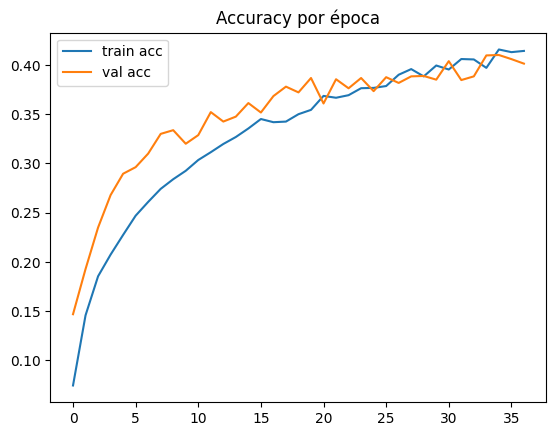

In [27]:
# ---------- TRAINING MODELS ----------

model1 = model_vgg16
model1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()


Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 101s 149ms/step - accuracy: 0.3855 - loss: 2.4592 - val_accuracy: 0.3901 - val_loss: 2.6454
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 147ms/step - accuracy: 0.3967 - loss: 2.4408 - val_accuracy: 0.3984 - val_loss: 2.6218
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - accuracy: 0.4060 - loss: 2.4192 - val_accuracy: 0.3821 - val_loss: 2.7211
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 96s 147ms/step - accuracy: 0.4074 - loss: 2.3852 - val_accuracy: 0.3876 - val_loss: 2.6552
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.4028 - loss: 2.4180 - val_accuracy: 0.3901 - val_loss: 2.6652
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 145ms/step - accuracy: 0.4103 - loss: 2.4007 - val_accuracy: 0.3859 - val_loss: 2.6698
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.4222 - loss: 2.3785 - val_accuracy: 0.3959 - val_loss: 2.6791
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.4256 

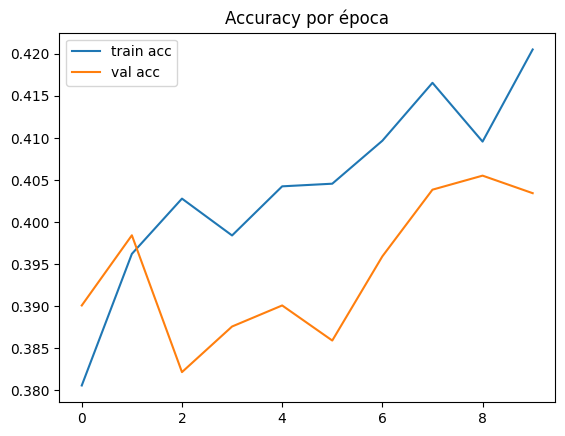

In [33]:
# ---------- TRAINING MODELS ----------

model1_1 = model_vgg16
model1_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model1_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 102s 151ms/step - accuracy: 0.4143 - loss: 2.3481 - val_accuracy: 0.4143 - val_loss: 2.5847
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 96s 147ms/step - accuracy: 0.4451 - loss: 2.2276 - val_accuracy: 0.4118 - val_loss: 2.5778
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.4558 - loss: 2.2246 - val_accuracy: 0.4134 - val_loss: 2.5710
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.4471 - loss: 2.2127 - val_accuracy: 0.4122 - val_loss: 2.5653
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.4623 - loss: 2.1839 - val_accuracy: 0.4180 - val_loss: 2.5651
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 96s 147ms/step - accuracy: 0.4599 - loss: 2.1571 - val_accuracy: 0.4155 - val_loss: 2.5599
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.4647 - loss: 2.1693 - val_accuracy: 0.4122 - val_loss: 2.5639
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 95s 146ms/step - accuracy: 0.4629 - loss: 

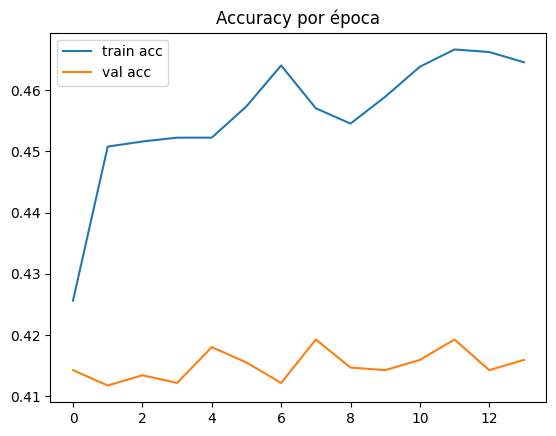

In [34]:
# ---------- TRAINING MODELS ----------

model1_2 = model_vgg16
model1_2.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model1_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 105s 144ms/step - accuracy: 0.0291 - loss: 5.1789 - val_accuracy: 0.0976 - val_loss: 4.7203
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.0809 - loss: 4.6984 - val_accuracy: 0.1160 - val_loss: 4.2429
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.1010 - loss: 4.3504 - val_accuracy: 0.1314 - val_loss: 4.1266
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 130ms/step - accuracy: 0.1123 - loss: 4.2135 - val_accuracy: 0.1514 - val_loss: 4.0356
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.1159 - loss: 4.1482 - val_accuracy: 0.1489 - val_loss: 4.0451
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 130ms/step - accuracy: 0.1226 - loss: 4.0740 - val_accuracy: 0.1510 - val_loss: 3.9612
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.1337 - loss: 4.0428 - val_accuracy: 0.1602 - val_loss: 3.8980
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.1334 - loss: 

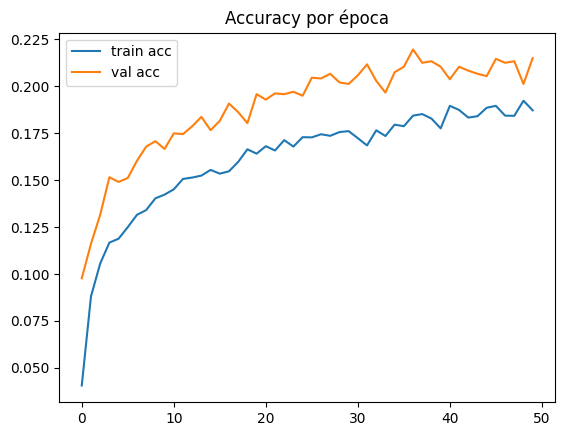

In [28]:
# ---------- TRAINING MODELS ----------

model2 = model_resnet
model2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()


Epoch 1/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 105s 145ms/step - accuracy: 0.1843 - loss: 3.6125 - val_accuracy: 0.2136 - val_loss: 3.6901
Epoch 2/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 87s 133ms/step - accuracy: 0.1917 - loss: 3.5876 - val_accuracy: 0.2073 - val_loss: 3.6847
Epoch 3/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 87s 132ms/step - accuracy: 0.1982 - loss: 3.5784 - val_accuracy: 0.2057 - val_loss: 3.6997
Epoch 4/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 87s 133ms/step - accuracy: 0.1912 - loss: 3.5811 - val_accuracy: 0.2182 - val_loss: 3.6896
Epoch 5/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 86s 132ms/step - accuracy: 0.1883 - loss: 3.5848 - val_accuracy: 0.2028 - val_loss: 3.7009
Epoch 6/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 86s 131ms/step - accuracy: 0.1983 - loss: 3.5711 - val_accuracy: 0.2053 - val_loss: 3.6904
Epoch 7/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 130ms/step - accuracy: 0.1970 - loss: 3.5636 - val_accuracy: 0.2078 - val_loss: 3.7041
Epoch 8/100
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.1955 

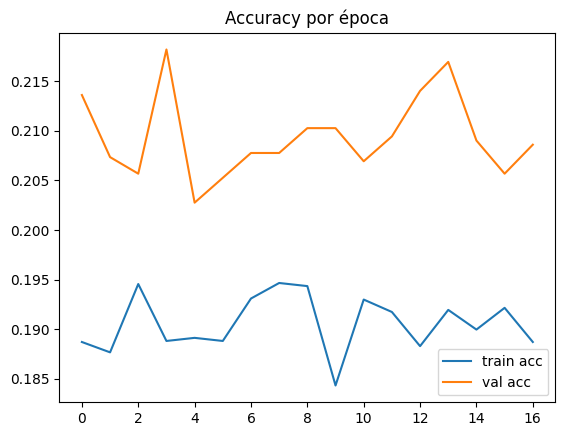

In [31]:
# ---------- TRAINING MODELS ----------

model2_1 = model_resnet
model2_1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model2_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()


Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 120s 155ms/step - accuracy: 0.0212 - loss: 5.2103 - val_accuracy: 0.0530 - val_loss: 4.9902
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 127ms/step - accuracy: 0.0488 - loss: 4.9687 - val_accuracy: 0.0772 - val_loss: 4.5852
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.0637 - loss: 4.6515 - val_accuracy: 0.0684 - val_loss: 4.4595
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.0737 - loss: 4.5050 - val_accuracy: 0.0951 - val_loss: 4.3829
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 127ms/step - accuracy: 0.0708 - loss: 4.4568 - val_accuracy: 0.0976 - val_loss: 4.3283
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 127ms/step - accuracy: 0.0773 - loss: 4.4039 - val_accuracy: 0.1043 - val_loss: 4.2807
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 127ms/step - accuracy: 0.0798 - loss: 4.3793 - val_accuracy: 0.1005 - val_loss: 4.2934
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.0813 - loss: 

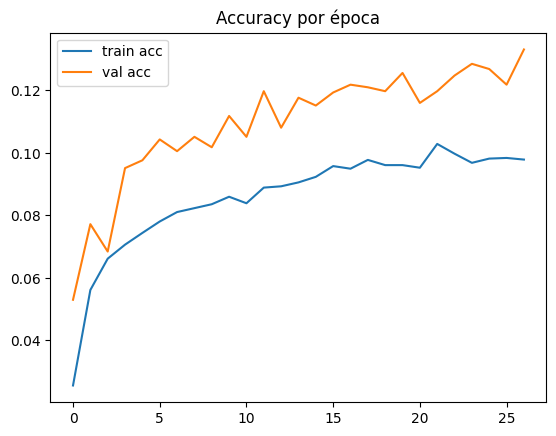

In [29]:
# ---------- TRAINING MODELS ----------

model3 = model_efficient
model3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()


In [32]:
# ---------- TRAINING MODELS ----------

model3_1 = model_efficient
model3_1.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model3_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 119s 153ms/step - accuracy: 0.1012 - loss: 4.2022 - val_accuracy: 0.1260 - val_loss: 4.1091
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.1078 - loss: 4.1590 - val_accuracy: 0.1239 - val_loss: 4.1100
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.1040 - loss: 4.1756 - val_accuracy: 0.1285 - val_loss: 4.1066
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.0975 - loss: 4.1651 - val_accuracy: 0.1289 - val_loss: 4.1036
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.1060 - loss: 4.1771 - val_accuracy: 0.1297 - val_loss: 4.1059
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.1037 - loss: 4.1589 - val_accuracy: 0.1297 - val_loss: 4.1009
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 83s 126ms/step - accuracy: 0.1032 - loss: 4.1583 - val_accuracy: 0.1268 - val_loss: 4.1004
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - accuracy: 0.1041 - loss: 

KeyboardInterrupt: 

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 96s 138ms/step - accuracy: 0.0274 - loss: 5.7646 - val_accuracy: 0.0388 - val_loss: 5.0682
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 86s 131ms/step - accuracy: 0.0411 - loss: 5.0732 - val_accuracy: 0.0601 - val_loss: 4.9626
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 130ms/step - accuracy: 0.0513 - loss: 4.9976 - val_accuracy: 0.0542 - val_loss: 4.9679
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 129ms/step - accuracy: 0.0525 - loss: 4.9497 - val_accuracy: 0.0526 - val_loss: 4.9714
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 86s 130ms/step - accuracy: 0.0580 - loss: 4.9136 - val_accuracy: 0.0626 - val_loss: 4.9261
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 130ms/step - accuracy: 0.0724 - loss: 4.8750 - val_accuracy: 0.0688 - val_loss: 4.9109
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 85s 130ms/step - accuracy: 0.0757 - loss: 4.8183 - val_accuracy: 0.0605 - val_loss: 4.9962
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 87s 133ms/step - accuracy: 0.0895 - loss: 4

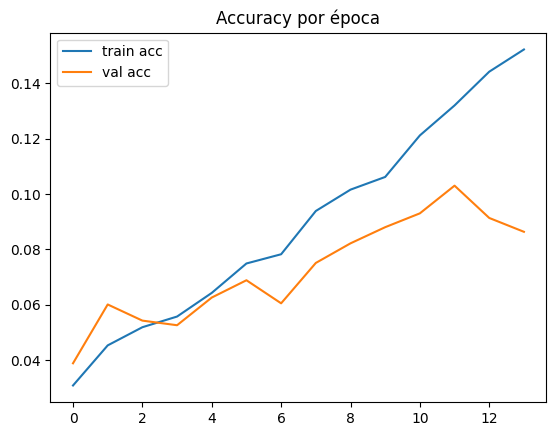

In [30]:
# ---------- TRAINING MODELS ----------

model4 = model_cnn
model4.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()


# Fine-tuning das camadas do ResNet



In [40]:
# ---------- DEFINIÇÃO DE MODELOS ----------
def build_pretrained_model_1(base_model, name, num_phyla, num_families):
    base_model.trainable = True
    image_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = base_model(image_input, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    x = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[image_input, phylum_input], outputs=output, name=name)

model_vgg16_1 = build_pretrained_model_1(
    tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3)),
    "VGG16_Model", len(phylum_lookup.get_vocabulary()), len(family_lookup.get_vocabulary()))

In [ ]:
# ---------- TRAINING MODELS ----------

model1 = model_vgg16_1
model1.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
    ]
)

# ---------------------------------------------
# FIM: Acurácia e histórico podem ser visualizados com:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy por época")
plt.show()

Epoch 1/50
